# Computer Vision Project: Plant Seedlings Classification

## Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## Problem statement

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species.

Our goal is to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

## Data description

This dataset contains images of unique plants belonging to 12 different species.

**List of Plant species**:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet



## Importing the necessary libraries

In [ ]:
#mounting the Google drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np                                                                               # Importing numpy for matrix operations
import pandas as pd                                                                              # Importing pandas manipulate DataFrames
import matplotlib.pyplot as plt                                                                  # Importing matplotlib for plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

#Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN models
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers for the models
from sklearn import preprocessing                                                                # Importing to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing to plot confusion matrices
from sklearn.metrics import classification_report                                                # Importing to plot classification reports for the models

#display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#formating numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

## Importing the data

In [ ]:
#loading the dataset of images
path1 = "/content/drive/MyDrive/Colab Notebooks/Intro to Computer Vision/images.npy"
images = np.load(path1)

#loading the dataset of labels
path2 = "/content/drive/MyDrive/Colab Notebooks/Intro to Computer Vision/Labels.csv"
labels = pd.read_csv(path2)

## Oveview of the dataset

In [ ]:
print(images.shape)
print(type(images))

(4750, 128, 128, 3)
<class 'numpy.ndarray'>


- The dataset contains 4750 RGB images of the shape 128x128 pixels, each containing 3 channels

In [ ]:
print(labels.shape)
print(type(labels))

(4750, 1)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
labels.sample(n=5)

,Label
810,Fat Hen
2475,Cleavers
270,Small-flowered Cranesbill
3113,Scentless Mayweed
2244,Charlock


## Exploratory data analysis

In [ ]:
#setting the figure size for the visualizations
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,10

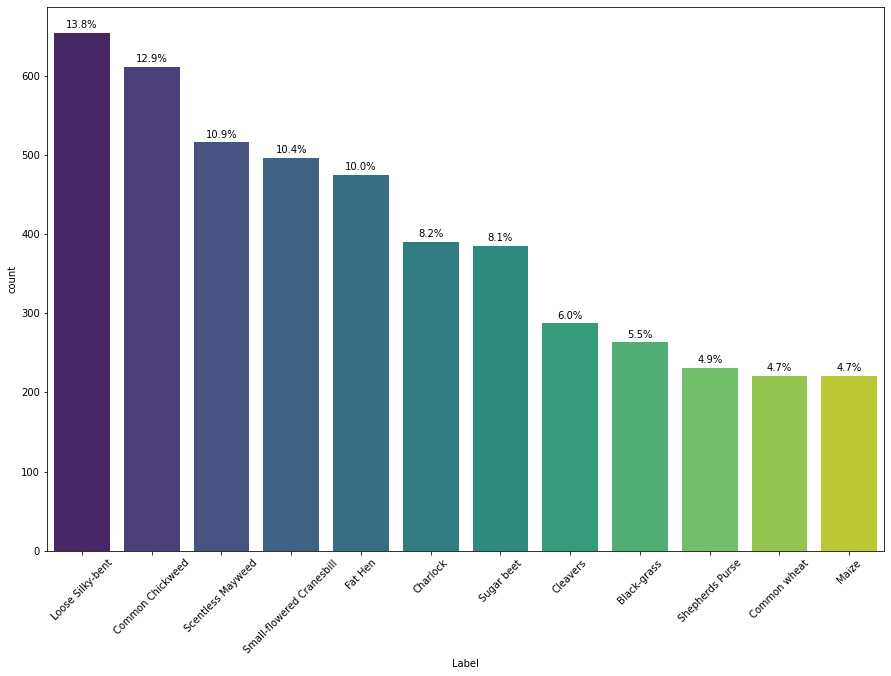

In [ ]:
#plotting the distribution of the number of each plant's images
ax = sns.countplot(data=labels, x="Label", palette='viridis', order = labels['Label'].value_counts().index)
total = float(len(images))
plt.xticks(rotation=45)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 6
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [ ]:
#displaying how many images of each plant are in the dataset
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

 - Of the 12 types of plants in the dataset:
  - Two plants, loose silky-bents and common chickweeds, comprise over a quarter (~26%) of all images
  - The five plants with the most images comprise 58% of all images

- The number of images for each plant ranges from 221 to 654, close to three times more images for the model to train with
- Since the distribution of the number of images for each plant is not uniform, there is the potential for the CNN model to overfit for the more well-represented plants
- Due to the nature of this project, this imbalance may also contribute to the model misclassifying less well-represented plants as better represented plants with similar shapes, colors, and other applicable traits


## Data visualization

In [ ]:
#listing the names of each class of plant
classes = np.unique(labels).tolist()
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
#storing the number of classes in a variable
num_classes = len(classes)
num_classes

12

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                                #setting the number of classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                    #obtaining the unique classes from labels
  rows = 3                                                                      #defining number of rows
  cols = 4                                                                      #defining number of columns
  fig = plt.figure(figsize=(15, 12))                                            #defining the figure size
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                      #generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                    #adding subplots
          ax.imshow(images[random_index, :])                                    #plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

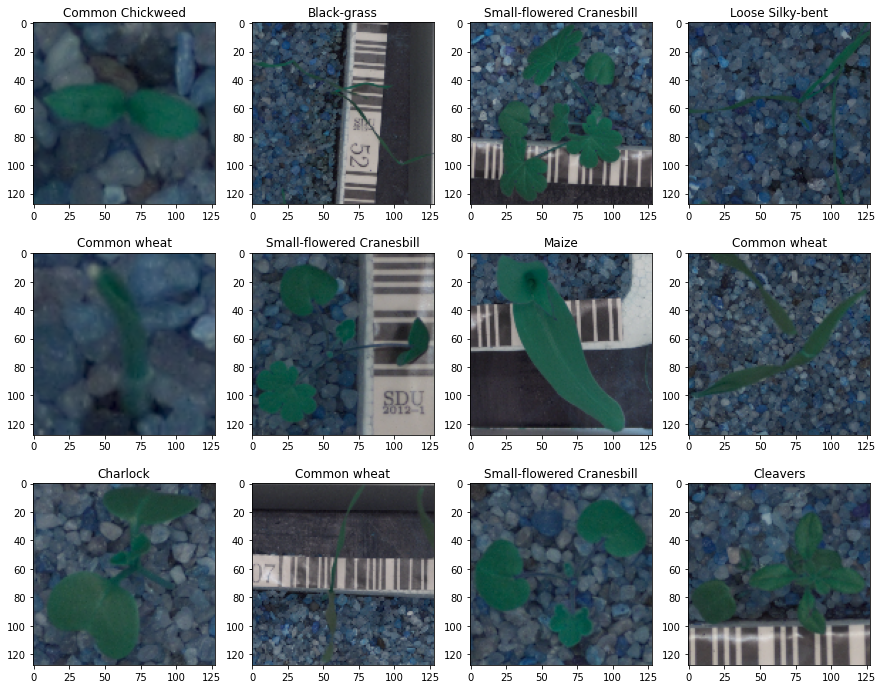

In [ ]:
#showing a sample of 12 images from the dataset
plot_images(images,labels)

- All of the plants appear to be various shapes and shades of green in a blue, rocky soil

## Data preperation

### Test on individual image

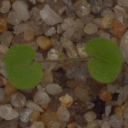

 
Small-flowered Cranesbill


In [ ]:
#showing an example image with its corresponding label
cv2_imshow(images[0])
print(" ")
print(labels['Label'].iloc[0])

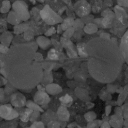

(128, 128)


In [ ]:
#converting the previous image into a grayscale
trial_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
#showing the image and printing its shape to confirm conversion
cv2_imshow(trial_image)
print(trial_image.shape)

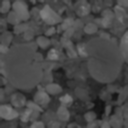

In [ ]:
#applying a Gaussian blur filter to the previous image
trial_image = cv2.GaussianBlur(trial_image, ksize =(3,3), sigmaX = 0)
#showing the image to confirm the blur
cv2_imshow(trial_image)

### Transform dataset

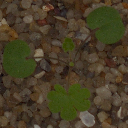

In [ ]:
#showing sample image to establish the look of original images
cv2_imshow(images[1])

In [ ]:
#applying Gaussian blur filter to all images in the dataset and storing in new array
new_images = []
for i in range(images.shape[0]):
   image = images[i]
   #image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   image=cv2.GaussianBlur(image, ksize =(3,3), sigmaX = 0)
   new_images.append(image)
new_images = np.array(new_images)

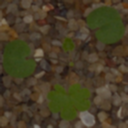

In [ ]:
#showing the previous image to confirm conversion
cv2_imshow(new_images[1])

### Split, normalize, and encode the dataset

In [ ]:
#splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(new_images, labels, test_size=0.1, random_state=42, stratify=labels)

To maximize the amount of data available to train the model, we are only using 10% of our data  for testing (475 images) and 90% for training (4275 images)

In [ ]:
#displaying the shape of x_train and x_test to confirm split
print(x_train.shape)
print(x_test.shape)

(4275, 128, 128, 3)
(475, 128, 128, 3)


In [ ]:
#normalizing the training image pixels
x_train_normalized = x_train.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
#creating one-hot encoded representation of target labels
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

## Model 1 - Base Convolutional Neural Network (CNN) Model

### Defining the model

In [ ]:
#clearing Keras backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#setting the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing a sequential model
model_1 = Sequential()

#adding first conv layer with 64 filters, a kernel size of 3x3, and padding as 'same', which provides the same output size as the input size
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3))) #input_shape denotes input image dimension of images
#adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
#adding batch normalization to reduce overfitting 
model_1.add(BatchNormalization())

#adding additional layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

#flattening the output of the conv layer after max pooling
model_1.add(Flatten())

#adding fully connected dense layers
model_1.add(Dense(64, activation='relu'))
#adding dropout layers to reduce overfitting
model_1.add(Dropout(0.25))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(16, activation='relu'))

#adding the output layer with 12 neurons and activation function of softmax, since this is a multi-class classification problem  
model_1.add(Dense(num_classes, activation='softmax'))

#using SGD optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

#compiling model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                        

### Model training

In [ ]:
#training the first model on preprocessed data
history_1 = model_1.fit(
            x_train_normalized, y_train_encoded,
            epochs=50,
            validation_split=0.1,
           # shuffle=True,
           verbose = 1
)

Epoch 1/50
121/121 [==============================] - 9s 29ms/step - loss: 2.4224 - accuracy: 0.1445 - val_loss: 2.7022 - val_accuracy: 0.1238
Epoch 2/50
121/121 [==============================] - 3s 24ms/step - loss: 2.0045 - accuracy: 0.3010 - val_loss: 2.9865 - val_accuracy: 0.1285
Epoch 3/50
121/121 [==============================] - 3s 24ms/step - loss: 1.8279 - accuracy: 0.3491 - val_loss: 3.1979 - val_accuracy: 0.1402
Epoch 4/50
121/121 [==============================] - 3s 21ms/step - loss: 1.6913 - accuracy: 0.3889 - val_loss: 1.6708 - val_accuracy: 0.3972
Epoch 5/50
121/121 [==============================] - 2s 17ms/step - loss: 1.6524 - accuracy: 0.3964 - val_loss: 1.9236 - val_accuracy: 0.2664
Epoch 6/50
121/121 [==============================] - 2s 17ms/step - loss: 1.5256 - accuracy: 0.4422 - val_loss: 2.9817 - val_accuracy: 0.2921
Epoch 7/50
121/121 [==============================] - 2s 17ms/step - loss: 1.4596 - accuracy: 0.4749 - val_loss: 1.6189 - val_accuracy: 0.3808

### Model evaluation on training data

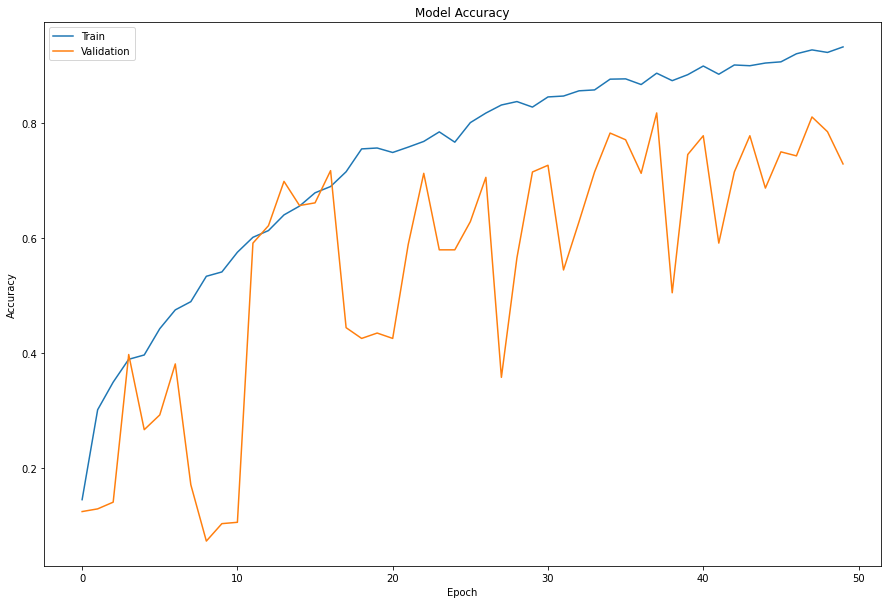

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Across 50 epochs:
  - The training accuracy gradually improved to close to 93%
  - The model's performance on the validation accuracy begins to be volatile but gradually improving around the 10th epoch
  - The validation accuracy at this plateau fluctuates between ~70-80%

- This performance signifies that the model is overfitting the training data and would not improve from additional epochs 

### Model evaluation on test data

In [ ]:
accuracy1 = model_1.evaluate(x_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.3098 - accuracy: 0.7326 - 176ms/epoch - 12ms/step


### Generating the predictions using test data

In [ ]:
#creating a dictionary to map model predictions to each plant's name
class_dict = {0:'Black-grass',
 1:'Charlock',
 2:'Cleavers',
 3:'Common Chickweed',
 4:'Common wheat',
 5:'Fat Hen',
 6:'Loose Silky-bent',
 7:'Maize',
 8:'Scentless Mayweed',
 9:'Shepherds Purse',
 10:'Small-flowered Cranesbill',
 11:'Sugar beet'}

In [ ]:
#making predictions on the test data
y_pred_test1 = model_1.predict(x_test_normalized)

#converting probabilities to class labels
y_pred_test_classes1 = np.argmax(y_pred_test1, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas1 = np.max(y_pred_test1, axis=1)

In [ ]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes1})
#replacing predictions with plant names
label_df = df.replace({"Labels":class_dict})
#converting dataframe to array
y_pred_test_classes1 = label_df.to_numpy()

### Plotting the confusion matrix

                           precision    recall  f1-score   support

              Black-grass       0.33      0.19      0.24        26
                 Charlock       0.97      0.90      0.93        39
                 Cleavers       0.91      0.69      0.78        29
         Common Chickweed       0.84      0.84      0.84        61
             Common wheat       0.85      0.50      0.63        22
                  Fat Hen       0.81      0.71      0.76        48
         Loose Silky-bent       0.62      0.89      0.73        65
                    Maize       0.68      0.77      0.72        22
        Scentless Mayweed       0.61      0.88      0.72        52
          Shepherds Purse       0.39      0.30      0.34        23
Small-flowered Cranesbill       0.89      0.82      0.85        50
               Sugar beet       0.82      0.61      0.70        38

                 accuracy                           0.73       475
                macro avg       0.73      0.68      0.69    

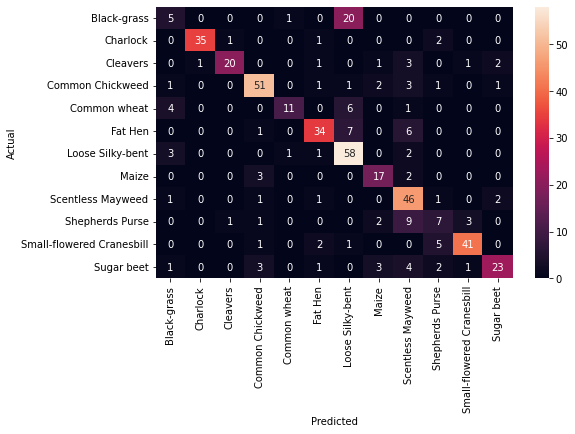

In [ ]:
#printing the classification report
print(classification_report(y_test, y_pred_test_classes1))

#plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes1)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- The model achieves 93% accuracy on the training data but only 76% accuracy on the testing data, indicating the model is overfit
- Additionally, we can observe from the classification report and the heat map that the model performs poorly on identifying certain classes:
  - For example, of the 26 images of black-grass, only 5 are identified correctly
  - Of note, the two the plants that the model performs the poorest on are also two out of the four plants with the fewest images available in the training data


## Model 2 - CNN Model with Data Augmentation

To improve the performance of the previous model, we will make two changes: 
- Add an additional set of a convolutional layer followed by a pooling layer and a batch normalization layer
- Add a Image Data Generator to augment training data

### Defining the model

In [ ]:
#clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#setting the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#creating Image Data Generator
train_datagen = ImageDataGenerator(horizontal_flip = True,
                              vertical_flip = True, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              fill_mode='nearest')

In [ ]:
#intializing a sequential model
model_2 = Sequential()

#adding first conv layer with 128 filters, a kernel size of 3x3, and padding as 'same', which provides the same output size as the input size
model_2.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3))) # Input_shape denotes input image dimension of images
#adding max pooling to reduce the size of output of first conv layer
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
#adding batch normalization to reduce overfitting 
model_2.add(BatchNormalization())

#adding additional layers
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())

#flattening the output of the conv layer
model_2.add(Flatten())

#adding a fully connected dense layers    
model_2.add(Dense(64, activation='relu'))
#adding dropout layers
model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(16, activation='relu'))

#adding the output layer with 12 neurons and activation functions as softmax, since this is a multi-class classification problem  
model_2.add(Dense(num_classes, activation='softmax'))

#using SGD optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

#compiling model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#generating the summary of the model
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                        

### Model training

In [ ]:
#setting number of epochs
epochs = 50
#setting the batch size of the generator
batch_size = 64

history_2 = model_2.fit(train_datagen.flow(x_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=x_train_normalized.shape[0] // batch_size,
                    validation_data=(x_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/50
66/66 [==============================] - 21s 295ms/step - loss: 2.2085 - accuracy: 0.2263 - val_loss: 3.5298 - val_accuracy: 0.1368
Epoch 2/50
66/66 [==============================] - 17s 258ms/step - loss: 1.6787 - accuracy: 0.4272 - val_loss: 8.4730 - val_accuracy: 0.1368
Epoch 3/50
66/66 [==============================] - 17s 259ms/step - loss: 1.4669 - accuracy: 0.4947 - val_loss: 6.4034 - val_accuracy: 0.1347
Epoch 4/50
66/66 [==============================] - 17s 258ms/step - loss: 1.3498 - accuracy: 0.5438 - val_loss: 9.3580 - val_accuracy: 0.1368
Epoch 5/50
66/66 [==============================] - 17s 258ms/step - loss: 1.2655 - accuracy: 0.5683 - val_loss: 6.9532 - val_accuracy: 0.1368
Epoch 6/50
66/66 [==============================] - 17s 260ms/step - loss: 1.1862 - accuracy: 0.6039 - val_loss: 3.1091 - val_accuracy: 0.1853
Epoch 7/50
66/66 [==============================] - 17s 257ms/step - loss: 1.1562 - accuracy: 0.6143 - val_loss: 3.9565 - val_accuracy: 0.2063

### Model evaluation on training data

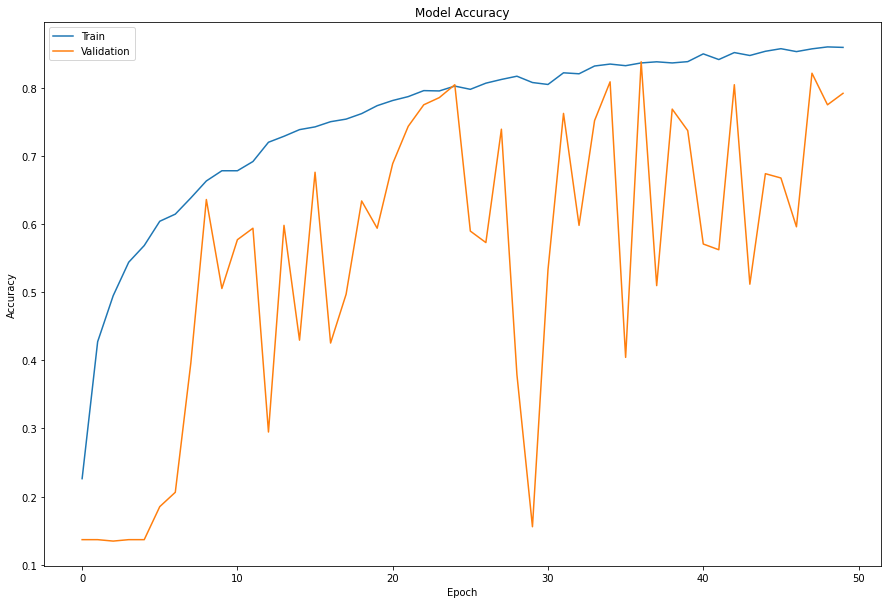

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Across 50 epochs:
  - The training accuracy gradually improved to close to 86%
  - From around the 9th epoch, the model's performance on the validation accuracy shows sporadic improvement but is highly volatile
- This performance signifies that the model is overfitting the training data and would not improve from additional epochs

### Model evaluation on test data

In [ ]:
accuracy2 = model_2.evaluate(x_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7098 - accuracy: 0.7916 - 148ms/epoch - 10ms/step


### Generating the predictions using test data

In [ ]:
# Here we would get the output as probablities for each category
y_pred2=model_2.predict(x_test_normalized)

### Generating the predictions using test data

In [ ]:
#making predictions on the test data
y_pred_test2 = model_2.predict(x_test_normalized)

#converting probabilities to class labels
y_pred_test_classes2 = np.argmax(y_pred_test2, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas2 = np.max(y_pred_test2, axis=1)

In [ ]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes2})
#replacing predictions with plant names
label_df = df.replace({"Labels":class_dict})
#converting dataframe to array
y_pred_test_classes2 = label_df.to_numpy()

### Plotting the confusion matrix

                           precision    recall  f1-score   support

              Black-grass       0.62      0.31      0.41        26
                 Charlock       0.97      0.92      0.95        39
                 Cleavers       0.88      0.72      0.79        29
         Common Chickweed       0.91      0.95      0.93        61
             Common wheat       0.85      0.50      0.63        22
                  Fat Hen       1.00      0.71      0.83        48
         Loose Silky-bent       0.72      0.80      0.76        65
                    Maize       0.73      1.00      0.85        22
        Scentless Mayweed       0.59      0.98      0.74        52
          Shepherds Purse       0.63      0.74      0.68        23
Small-flowered Cranesbill       1.00      0.64      0.78        50
               Sugar beet       0.79      0.89      0.84        38

                 accuracy                           0.79       475
                macro avg       0.81      0.76      0.77    

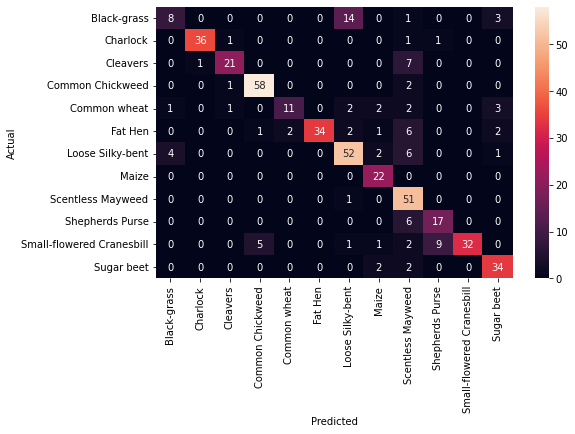

In [ ]:
#printing the classification report
print(classification_report(y_test, y_pred_test_classes2))

#plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes2)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- Overall, our additions do not appear to have improved the CNN's performance
  - The model achieves 86% accuracy on the training data and a 79% accuracy on the testing data, indicating the model is overfit

- However, we can observe from the classification report and the heat map that the model performs better on identifying less well-represented classes in the training data


## Model 3: Transfer Learning with VGG 16

- We will now implement transfer learning with a VGG 16 model, setting the lowest convolutional layer as trainable to adapt this feature identification layer to identify plants
- Since our second model performed better on under-represented plant images, we will keep the Image Data Generator in this model

In [ ]:
#clearing backend
backend.clear_session()

In [ ]:
#setting the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#importing the convolutional layers of the VGG 16 model
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
num_layers = len(vgg_model.layers)
# setting all of layers of the VGG model to non-trainable except the two lowest
for layer in vgg_model.layers[:num_layers-2]:
    layer.trainable = False

In [ ]:
#confirming non-trainable and trainable layers
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
#creating new sequential model
model_3 = Sequential()

#adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

#flattening the output of the VGG16 model
model_3.add(Flatten())

#adding the fully connected dense layers    
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(16, activation='relu'))

#adding the output layer with 12 neurons and activation functions as softmax, since this is a multi-class classification problem  
model_3.add(Dense(num_classes, activation='softmax'))

#using SGD optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

#compiling model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#generating the summary of the model
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

### Model training

In [ ]:
#setting number of epochs
epochs = 70
#setting the batch size of the generator
batch_size = 64

history_3 = model_3.fit(train_datagen.flow(x_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=x_train_normalized.shape[0] // batch_size,
                    validation_data=(x_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/70
66/66 [==============================] - 20s 284ms/step - loss: 2.4693 - accuracy: 0.1133 - val_loss: 2.4008 - val_accuracy: 0.1558
Epoch 2/70
66/66 [==============================] - 17s 264ms/step - loss: 2.3610 - accuracy: 0.1736 - val_loss: 2.2644 - val_accuracy: 0.2632
Epoch 3/70
66/66 [==============================] - 17s 263ms/step - loss: 2.1639 - accuracy: 0.2717 - val_loss: 1.9615 - val_accuracy: 0.3179
Epoch 4/70
66/66 [==============================] - 17s 264ms/step - loss: 1.9084 - accuracy: 0.3472 - val_loss: 1.7320 - val_accuracy: 0.4063
Epoch 5/70
66/66 [==============================] - 17s 263ms/step - loss: 1.7300 - accuracy: 0.3826 - val_loss: 1.5501 - val_accuracy: 0.4505
Epoch 6/70
66/66 [==============================] - 17s 262ms/step - loss: 1.6138 - accuracy: 0.4184 - val_loss: 1.4737 - val_accuracy: 0.4737
Epoch 7/70
66/66 [==============================] - 17s 263ms/step - loss: 1.4617 - accuracy: 0.4776 - val_loss: 1.3164 - val_accuracy: 0.5537

### Model evaluation on training data

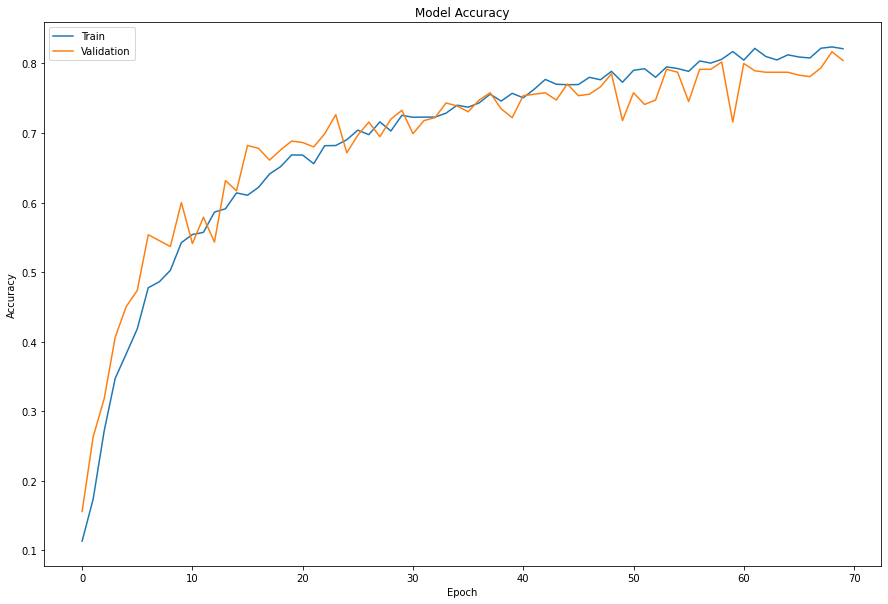

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Across 70 epochs:
  - The training accuracy gradually improved to ~82%
  - The model's performance on the validation accuracy plateaus at ~80% in around 60 training epochs
  - However, most importantly, in the final 10 epochs the validation accuracy appears reliably at 80% plus or minus 1%.

- This performance signifies that the model overfit the training data in the later epochs and would not benefit from additional epochs 

### Model evaluation on test data

In [ ]:
accuracy3 = model_3.evaluate(x_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7144 - accuracy: 0.8042 - 425ms/epoch - 28ms/step


### Generating the predictions using test data

In [ ]:
#making predictions on the test data
y_pred_test3 = model_3.predict(x_test_normalized)

#converting probabilities to class labels
y_pred_test_classes3 = np.argmax(y_pred_test3, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas3 = np.max(y_pred_test3, axis=1)

In [ ]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes3})
#replacing predictions with plant names
label_df = df.replace({"Labels":class_dict})
#converting dataframe to array
y_pred_test_classes3 = label_df.to_numpy()

### Plotting the confusion matrix

                           precision    recall  f1-score   support

              Black-grass       0.58      0.42      0.49        26
                 Charlock       0.83      0.90      0.86        39
                 Cleavers       0.92      0.83      0.87        29
         Common Chickweed       0.92      0.90      0.91        61
             Common wheat       0.51      0.82      0.63        22
                  Fat Hen       0.77      0.77      0.77        48
         Loose Silky-bent       0.76      0.82      0.79        65
                    Maize       0.80      0.91      0.85        22
        Scentless Mayweed       0.79      0.81      0.80        52
          Shepherds Purse       0.92      0.52      0.67        23
Small-flowered Cranesbill       0.94      0.88      0.91        50
               Sugar beet       0.84      0.82      0.83        38

                 accuracy                           0.80       475
                macro avg       0.80      0.78      0.78    

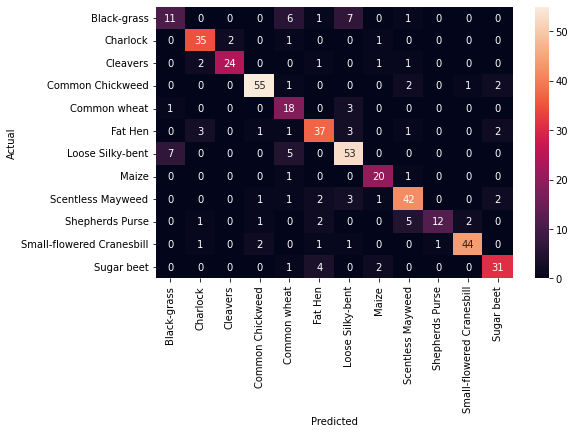

In [ ]:
#printing the classification report
print(classification_report(y_test, y_pred_test_classes3))

#plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes3)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- Overall, this derivation of the VGG 16 model appears perform the best of all three models
  - The model achieves 82% accuracy on the training data, 80% accuracy on the validation data, and 80% accuracy on the testing data, which indicates the model overfit in the later epochs but should perform consistently during future implementations

- Additionally, we can observe from the classification report and the heat map that the model performs the best at identifying less well-represented classes in the training data


## Conclusion

In [ ]:
#creating list of predictions for all models generated
y_pred_tests = [y_pred_test_classes1,y_pred_test_classes2,y_pred_test_classes3]

modelx = 1

#generating classification reports for all models
for y_pred in y_pred_tests:
  print("Model "+str(modelx))
  print(classification_report(y_test,y_pred))
  print(" ")
  modelx+=1

Model 1
                           precision    recall  f1-score   support

              Black-grass       0.33      0.19      0.24        26
                 Charlock       0.97      0.90      0.93        39
                 Cleavers       0.91      0.69      0.78        29
         Common Chickweed       0.84      0.84      0.84        61
             Common wheat       0.85      0.50      0.63        22
                  Fat Hen       0.81      0.71      0.76        48
         Loose Silky-bent       0.62      0.89      0.73        65
                    Maize       0.68      0.77      0.72        22
        Scentless Mayweed       0.61      0.88      0.72        52
          Shepherds Purse       0.39      0.30      0.34        23
Small-flowered Cranesbill       0.89      0.82      0.85        50
               Sugar beet       0.82      0.61      0.70        38

                 accuracy                           0.73       475
                macro avg       0.73      0.68      

- We can observe from the classification reports of all the models that our third model performs incrementally better than the second model, but should produce far more consistent results in production
- Data augmentation has also helped the model to be able to identify less well-represented plants
- However, even with these steps and after 70 epochs, the VGG 16 model does not appear to be able classify three out of four of the plants with the fewest images as reliably as the other nine plants in the dataset

## Scope of Improvement

- All of these models would most likely improve by having more images available of less well-represented plants during training
- These models can be further improved by training with different filter sizes and different number of filters
- Different combinations of hyperparameters in the convolutional layers and ANN layers can be tested to improve the model performance, such as through a randomized grid search
- Other transfer learning architectures can also be used to train the CNN model and these models can be used for classification